<a href="https://colab.research.google.com/github/edrc1999/Daniel-Ramos-/blob/main/Semena2/RNN/Taller_Forecasting_Ocupacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
# Cargar dataset de ocupacion de sitios de parqueo
data = pd.read_csv("/SJ.csv")

In [62]:
# Revisar cabecera y cola del dataset
data.head()

,date,idCompany,numTrx
0,2022-08,1,68599
1,2022-09,1,86862
2,2022-10,1,99611
3,2022-11,1,109018
4,2022-12,1,115665


In [63]:
data.tail()

,date,idCompany,numTrx
13,2023-09,1,126851
14,2023-10,1,137539
15,2023-11,1,145327
16,2023-12,1,135537
17,2024-01,1,148111


In [115]:
# Formatear la columna de fecha como año y mes
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.strftime('%Y-%m')
data.head()

,date,numTrx,numPark_escaled,numTrx_escaled,numTrx_scaled
0,2022-08,68599,-1.000000,-1.000000,-1.000000
1,2022-09,86862,-0.540623,-0.540623,-0.540623
2,2022-10,99611,-0.219942,-0.219942,-0.219942
3,2022-11,109018,0.016677,0.016677,0.016677
4,2022-12,115665,0.183872,0.183872,0.183872


In [52]:
# Verificar el nombre de los meses del dataset para comprobar que el formateo es correcto
data['date'].unique()

array(['2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01',
       '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
       '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01'],
      dtype=object)

In [116]:
# Contar el numero de datos del dataset
data.shape

(18, 5)

In [54]:
# Obtener una estadistica descriptiva básica del dataset, verificar si hay algo anormal
data.describe()

,idCompany,numTrx
count,18.0,18.000000
mean,1.0,120111.833333
std,0.0,20840.047288
min,1.0,68599.000000
25%,1.0,110679.750000
50%,1.0,125518.500000
75%,1.0,135321.000000
max,1.0,148111.000000


In [55]:
# Revisar si el ldataset tiene datos nullos
data.isnull().sum()

,0
date,0
idCompany,0
numTrx,0


In [56]:
# Establecer el campo fecha como index del dataframe
data.set_index('date', inplace=True)


In [104]:
# Verificar nuevamente el head de la tabla y comprobar que el index ahora sea la fecha
data.head()

,date,numTrx,numPark_escaled,numTrx_escaled,numTrx_scaled
0,2022-08,68599,-1.000000,-1.000000,-1.000000
1,2022-09,86862,-0.540623,-0.540623,-0.540623
2,2022-10,99611,-0.219942,-0.219942,-0.219942
3,2022-11,109018,0.016677,0.016677,0.016677
4,2022-12,115665,0.183872,0.183872,0.183872


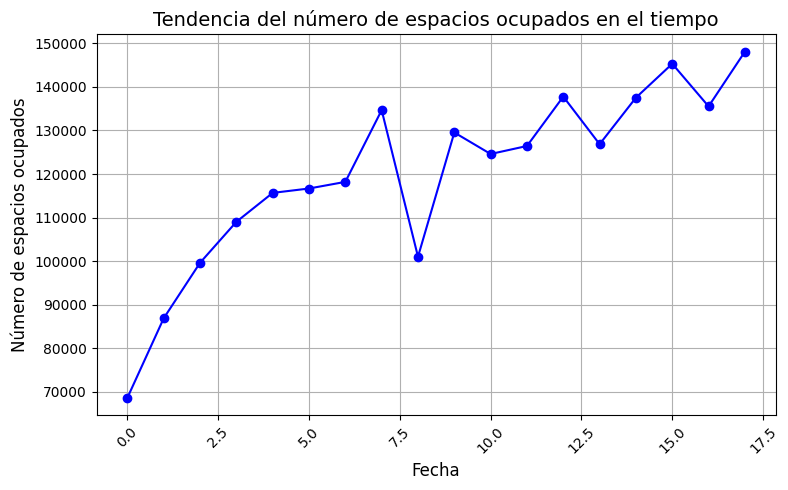

In [67]:
# Realizar una grafica de tendencia del numero de espacios ocupados en el tiempo
plt.figure(figsize=(8, 5))
plt.plot(data.index, data['numTrx'], marker='o', linestyle='-', color='b')

# Etiquetas y título
plt.title('Tendencia del número de espacios ocupados en el tiempo', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de espacios ocupados', fontsize=12)

# Mostrar la gráfica
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
# Eliminar las columnas que no necesiten para realizar un sistema de prediccion de ocupacion de parqueo
data = data.drop(['idCompany'], axis=1)
data.head()


,date,numTrx
0,2022-08,68599
1,2022-09,86862
2,2022-10,99611
3,2022-11,109018
4,2022-12,115665


In [83]:
# Escalar entre -1 y 1 los datos de la variable a predecir
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data['numTrx_scaled'] = scaler.fit_transform(data['numTrx'].values.reshape(-1, 1))
print (data)

       date  numTrx  numPark_escaled  numTrx_escaled  numTrx_scaled
0   2022-08   68599        -1.000000       -1.000000      -1.000000
1   2022-09   86862        -0.540623       -0.540623      -0.540623
2   2022-10   99611        -0.219942       -0.219942      -0.219942
3   2022-11  109018         0.016677        0.016677       0.016677
4   2022-12  115665         0.183872        0.183872       0.183872
5   2023-01  116672         0.209201        0.209201       0.209201
6   2023-02  118194         0.247485        0.247485       0.247485
7   2023-03  134673         0.661988        0.661988       0.661988
8   2023-04  100997        -0.185079       -0.185079      -0.185079
9   2023-05  129538         0.532825        0.532825       0.532825
10  2023-06  124599         0.408592        0.408592       0.408592
11  2023-07  126438         0.454850        0.454850       0.454850
12  2023-08  137782         0.740190        0.740190       0.740190
13  2023-09  126851         0.465238        0.46

In [86]:
# Definir una ventana temporal adecuada para la prediccion y establecer las listas
# xtrain y ytrain para el entrenamiento
window_size = 2
x_train = []
y_train = []

for i in range(len(data) - window_size):
    x_train.append(data['numTrx_scaled'].iloc[i:i+window_size].values)
    y_train.append(data['numTrx_scaled'].iloc[i+window_size])


In [87]:
from re import X
# Convertir las listas en arrays de numpy
x_train = np.array(x_train)
y_train = np.array(y_train)
print (x_train)
print (y_train)

[[-1.         -0.5406228 ]
 [-0.5406228  -0.21994164]
 [-0.21994164  0.01667673]
 [ 0.01667673  0.18387162]
 [ 0.18387162  0.20920113]
 [ 0.20920113  0.24748466]
 [ 0.24748466  0.66198813]
 [ 0.66198813 -0.18507898]
 [-0.18507898  0.53282523]
 [ 0.53282523  0.40859241]
 [ 0.40859241  0.45484958]
 [ 0.45484958  0.74019016]
 [ 0.74019016  0.46523795]
 [ 0.46523795  0.73407788]
 [ 0.73407788  0.92997283]
 [ 0.92997283  0.6837207 ]]
[-0.21994164  0.01667673  0.18387162  0.20920113  0.24748466  0.66198813
 -0.18507898  0.53282523  0.40859241  0.45484958  0.74019016  0.46523795
  0.73407788  0.92997283  0.6837207   1.        ]


In [88]:
# Verificar el shape de los datos de entrenamiento (variable independiente y dependiente)
print(x_train.shape)
print(y_train.shape)

(16, 2)
(16,)


In [90]:
# Construir un modelo LSTM para realizar la predicción que tenga la siguiente arquitectura

# Una capa LSTM de 256 neuronas con activación relu
# Una capa LSTM de 256 neuronas con activación relu
# Una capa LSTM de 128 neuronas con activación relu
# Una capa LSTM de 64 neuronas con activación relu
# Una capa LSTM de 32 neuronas con activación relu
# Una capa LSTM de 16 neuronas con activación relu (esta seria la ultima capa LSTM)
# Agregar operaciones de Dropout de 7% despues de cada capa LSTM
# Agregar en la etapa final una red densa con dos capas con 64 neuronas y 32 neuronas
# Finalmente agregar una capa densa de salida
# Imprimir el summary del  modelo

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(3, 1)))
model.add(Dropout(0.1))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.07))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 3, 256)              │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 3, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 3, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 3, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,054,785 (4.02 MB)

 Trainable params: 1,054,785 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Compilar el modelo con una funcion de error mse y un optimizador adam
model.compile(optimizer='adam', loss='mean_squared_error')


In [93]:
# Entrenar el modelo durante 100 epocas
# Usar el 10% de los datos de entrenamiento para validacion
# Usar un batch size de 16
history = model.fit(x_train,y_train, epochs=100, batch_size=16,validation_split=0.1)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0671 - val_loss: 0.0086
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0741 - val_loss: 0.0185
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.0630 - val_loss: 0.0219
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0685 - val_loss: 0.0170
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0697 - val_loss: 0.0101
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0782 - val_loss: 0.0084
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0704 - val_loss: 0.0083
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0717 - val_loss: 0.0082
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0679 - val_loss: 0.0083
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0641 - val_loss: 0.0117
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0761 - val_loss: 0.0275
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0639 

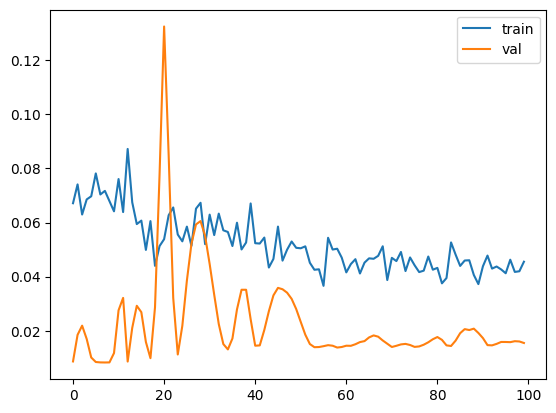

In [94]:
# Grafifcar el loss y loss de validacion para verificar que no haya overfitting
plt.plot(history.history["loss"],label = "train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()


In [95]:
# Guardar el modelo y salvarlo en disco
model.save("model_ocup.h5")

In [111]:
# Tome N registros historicos de su dataset y realice la predicción de ocupación para un mes particular
predN = data['numTrx_scaled'].values[-5:]
predN = np.reshape(predN, (1, 5, 1))
predic_esc = model.predict(predN)
predic_val = scaler.inverse_transform(predic_esc)
print ("para el mes 5 la prediccion sera " ,predic_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
para el mes 5 la prediccion sera  [[3372104.5]]


In [114]:
# Proponga una arquitectura que permita recibir como parametros de entrada no solo los historicos de la
# serie temporal sino tambien información adicional relevante como por ejemplo el mes para el cual se
# realiza la predicción, o el número de dias festivos del mes de predicción
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
n_features = 1
input_time_series = Input(shape=(N, n_features), name='time_series_input')
lstm = LSTM(256, activation='relu', return_sequences=True)(input_time_series)
lstm = Dropout(0.08)(lstm)
lstm = LSTM(256, activation='relu', return_sequences=True)(lstm)
lstm = Dropout(0.08)(lstm)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = Dropout(0.08)(lstm)
lstm = LSTM(64, activation='relu', return_sequences=True)(lstm)
lstm = Dropout(0.08)(lstm)
lstm = LSTM(32, activation='relu', return_sequences=True)(lstm)
lstm = Dropout(0.08)(lstm)
lstm = LSTM(16, activation='relu')(lstm)
lstm = Dropout(0.08)(lstm)
input_additional_features = Input(shape=(2,), name='additional_features_input')
dense_additional = Dense(32, activation='relu')(input_additional_features)
concat = Concatenate()([lstm, dense_additional])
dense = Dense(64, activation='relu')(concat)
dense = Dense(32, activation='relu')(dense)
output = Dense(1)(dense)
model = Model(inputs=[input_time_series, input_additional_features], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time_series_input         │ (None, 4, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_18 (LSTM)            │ (None, 4, 256)         │        264,192 │ time_series_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 4, 256)         │              0 │ lstm_18[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ (None, 4, 256)         │        525,312 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 4, 256)         │              0 │ lstm_19[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ (None, 4, 128)         │        197,120 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 4, 128)         │              0 │ lstm_20[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ (None, 4, 64)          │         49,408 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 4, 64)          │              0 │ lstm_21[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ (None, 4, 32)          │         12,416 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 4, 32)          │              0 │ lstm_22[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ (None, 16)             │          3,136 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_features_input │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 16)             │              0 │ lstm_23[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │             96 │ additional_features_i… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 48)             │              0 │ dropout_23[0][0],      │
│ (Concatenate)             │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │          3,136 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 32)             │          2,080 │ dense_11[0][0]         │
├──────────────────────

 Total params: 1,056,929 (4.03 MB)

 Trainable params: 1,056,929 (4.03 MB)

 Non-trainable params: 0 (0.00 B)